SKIN DISEASE DETECTION-----CHATBOT

Importing libraries

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

Mounting Drive into colab

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_dir = '/content/drive/MyDrive/skin-cancer-mnist-ham10000-processed'

In [5]:
Labels = ['Actinic keratoses and intraepithelial carcinoma / Bowens disease ','basal cell carcinoma','benign keratosis-like lesions',' dermatofibroma','melanoma',' melanocytic nevi','vascular lesions']

In [6]:
print ("class : ") 
for i in range(len(Labels)): 
    print (i, end = " ") 
    print (Labels[i])
print('Number of classes:',len(Labels))

class : 
0 Actinic keratoses and intraepithelial carcinoma / Bowens disease 
1 basal cell carcinoma
2 benign keratosis-like lesions
3  dermatofibroma
4 melanoma
5  melanocytic nevi
6 vascular lesions
Number of classes: 7


In [7]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16 

In [8]:
IMAGE_SIZE

(224, 224)

In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.3)
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 283 images belonging to 7 classes.
Found 120 images belonging to 7 classes.


In [10]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE])
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 2,917,447
Trainable params: 659,463
Non-trainable params: 2,257,984
___________________

In [13]:
LEARNING_RATE = 0.001 
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])
EPOCHS=15
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/15
17/17 [==============================] - 29s 2s/step - loss: 0.2091 - accuracy: 0.9401 - val_loss: 0.0769 - val_accuracy: 0.9643
Epoch 2/15
17/17 [==============================] - 26s 2s/step - loss: 0.1159 - accuracy: 0.9738 - val_loss: 0.1274 - val_accuracy: 0.9196
Epoch 3/15
17/17 [==============================] - 26s 2s/step - loss: 0.0568 - accuracy: 0.9850 - val_loss: 0.1063 - val_accuracy: 0.9554
Epoch 4/15
17/17 [==============================] - 24s 1s/step - loss: 0.0520 - accuracy: 0.9738 - val_loss: 0.1122 - val_accuracy: 0.9643
Epoch 5/15
17/17 [==============================] - 21s 1s/step - loss: 0.0853 - accuracy: 0.9588 - val_loss: 0.0761 - val_accuracy: 0.9643
Epoch 6/15
17/17 [==============================] - 26s 2s/step - loss: 0.0454 - accuracy: 0.9888 - val_loss: 0.0754 - val_accuracy: 0.9821
Epoch 7/15
17/17 [==============================] - 22s 1s/step - loss: 0.0586 - accuracy: 0.9775 - val_loss: 0.1186 - val_accuracy: 0.9732
Epoch 8/15
17/17 [==

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

1/1 [==============================] - 1s 621ms/step
class: vascular lesions, confidence: 0.958545


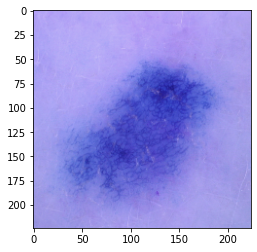

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 61ms/step
class:  melanocytic nevi, confidence: 0.992990


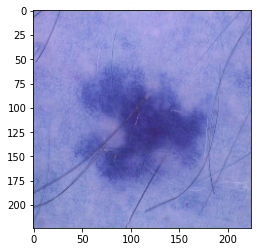

1/1 [==============================] - 0s 66ms/step
class:  melanocytic nevi, confidence: 0.972940


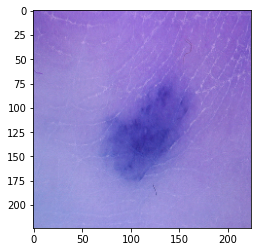

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 55ms/step
class: vascular lesions, confidence: 0.996182


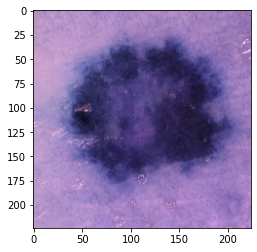

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 56ms/step
class:  melanocytic nevi, confidence: 0.999988


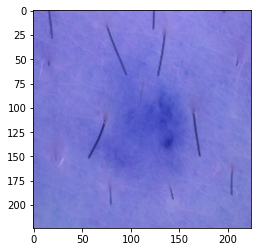

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 59ms/step
class: vascular lesions, confidence: 0.979286


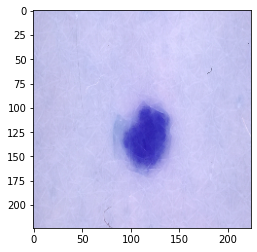

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 54ms/step
class: vascular lesions, confidence: 0.758372


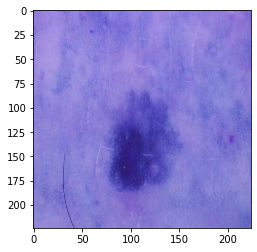

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 56ms/step
class:  melanocytic nevi, confidence: 0.964293


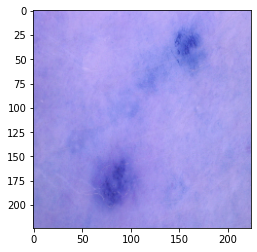

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 60ms/step
class: vascular lesions, confidence: 0.999487


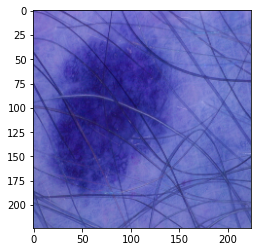

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 94ms/step
class:  melanocytic nevi, confidence: 0.999321


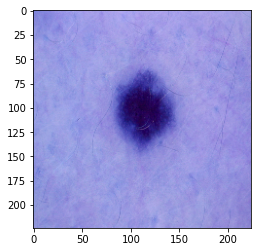

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 106ms/step
class: vascular lesions, confidence: 0.565445


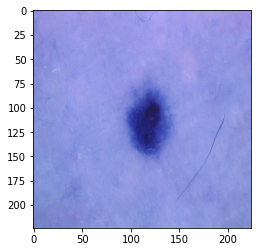

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 99ms/step
class: vascular lesions, confidence: 0.986711


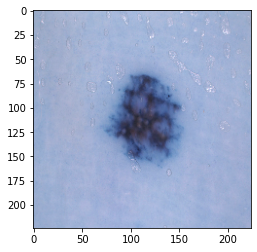

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 103ms/step
class: vascular lesions, confidence: 0.999413


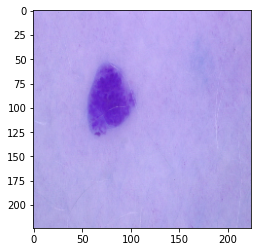

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 125ms/step
class:  melanocytic nevi, confidence: 0.891160


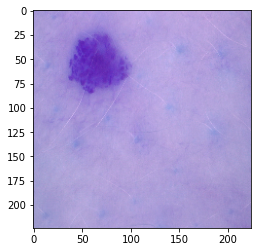

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 101ms/step
class:  melanocytic nevi, confidence: 0.873472


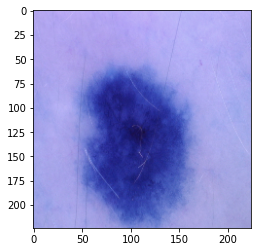

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 91ms/step
class: vascular lesions, confidence: 0.949097


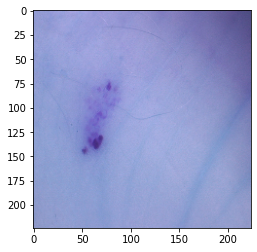

<Figure size 432x288 with 0 Axes>

In [ ]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    return img

def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    return {Labels[classx]: x[classx]}
images = random.sample(validation_generator.filenames, 16)

for idx, filename in enumerate(images):
    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
y= validation_generator.classes
cm = confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)

Confusion Matrix


ValueError: ignored

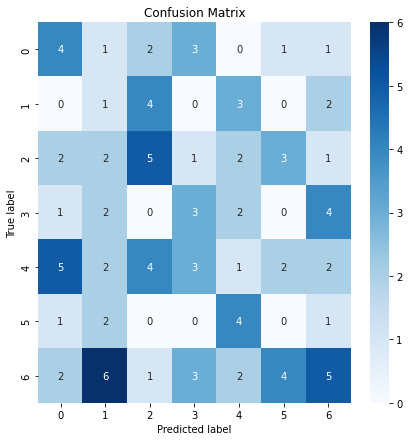

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# create example data with 7 classes
y_true = np.random.randint(0, 7, size=100)
y_pred = np.random.randint(0, 7, size=100)

# compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# create heatmap visualization
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

# customize plot settings
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')
plt.show()


In [1]:
model.summary()

NameError: ignored